In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.tokenize import word_tokenize
import warnings
import joblib
import re

In [2]:
# importing dataset
dataset_columns = ["target", "ids", "date", "flag", "user", "text"]
dataset_encode = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = dataset_encode, names = dataset_columns)

In [3]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.isnull().any()

target    False
ids       False
date      False
flag      False
user      False
text      False
dtype: bool

In [5]:
data['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

In [6]:
t = []
for i in data.target.values:
    if i ==0: t.append(0)
    else: t.append(1)
        
df = pd.DataFrame({"text":data.text.values, "target":t})
print("positive, negative :", set(df.target))

positive, negative : {0, 1}


In [7]:
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [8]:
df[df['target'] == 0].head(10)

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
5,@Kwesidei not the whole crew,0
6,Need a hug,0
7,@LOLTrish hey long time no see! Yes.. Rains a...,0
8,@Tatiana_K nope they didn't have it,0
9,@twittera que me muera ?,0


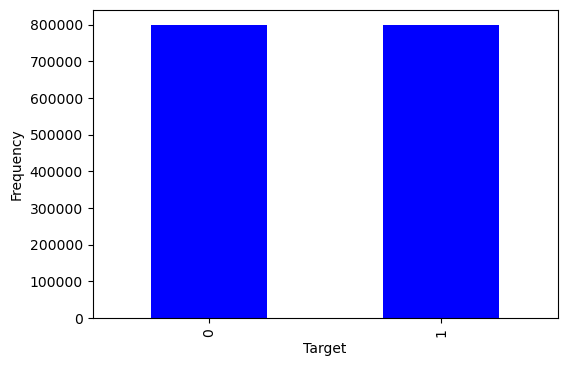

In [50]:
# df['target'].value_counts().plot.bar(color = 'blue', figsize = (6, 4))
# ax.set_xlabel('Target')
# ax.set_ylabel('Frequency')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
df['target'].value_counts().plot(kind='bar', color='blue', ax=ax)
ax.set_xlabel('Target')
ax.set_ylabel('Frequency')
plt.show()


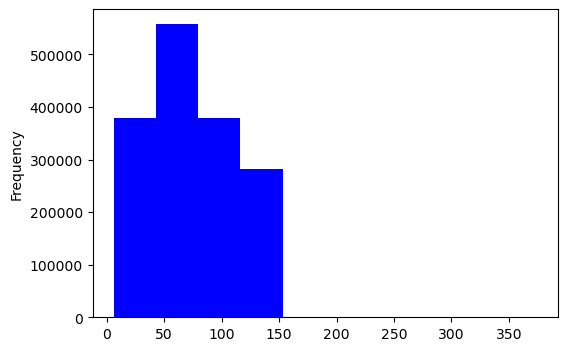

In [10]:
length_train = df['text'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

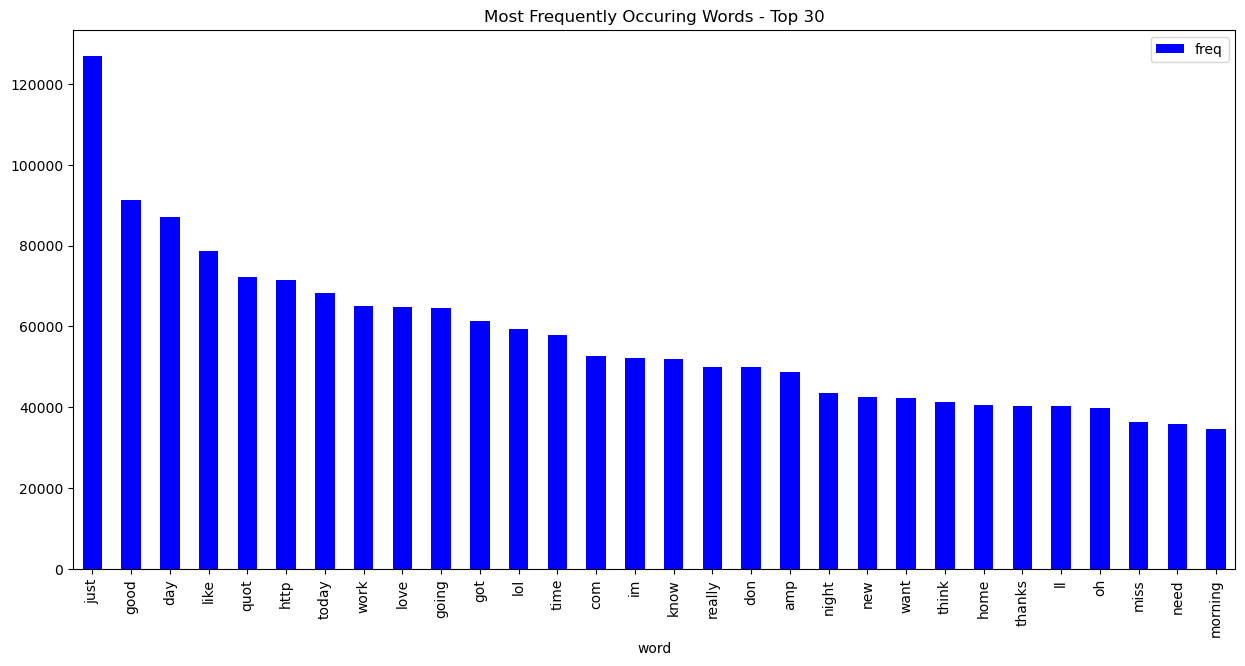

In [11]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.text)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

In [12]:
!pip install wordcloud

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

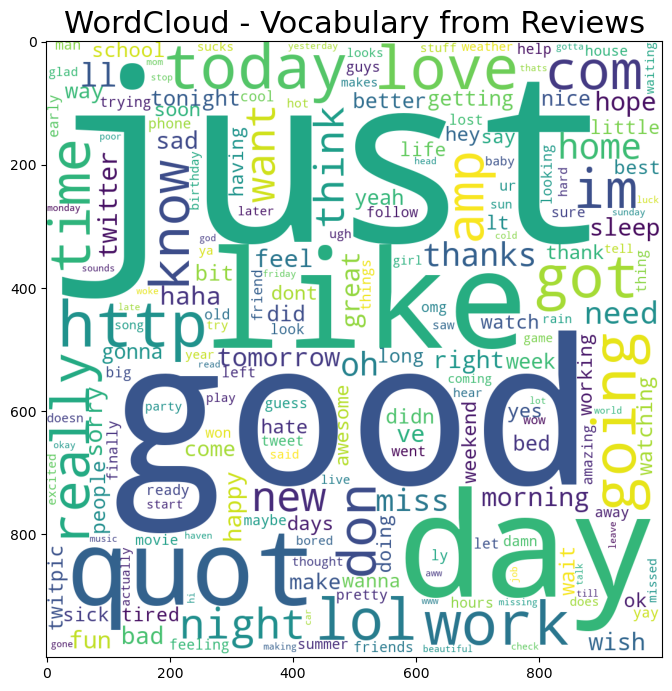

In [13]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

In [14]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [15]:
import re

In [16]:
# extracting hashtags from positive tweets
HT_regular = hashtag_extract(df['text'][df['target'] == 0])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df['text'][df['target'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [17]:
import nltk

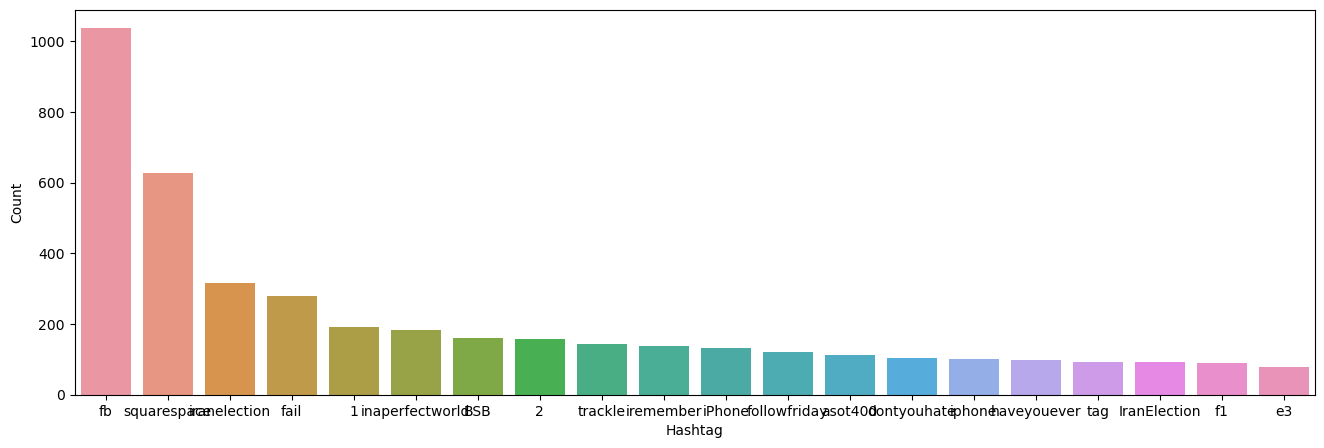

In [18]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

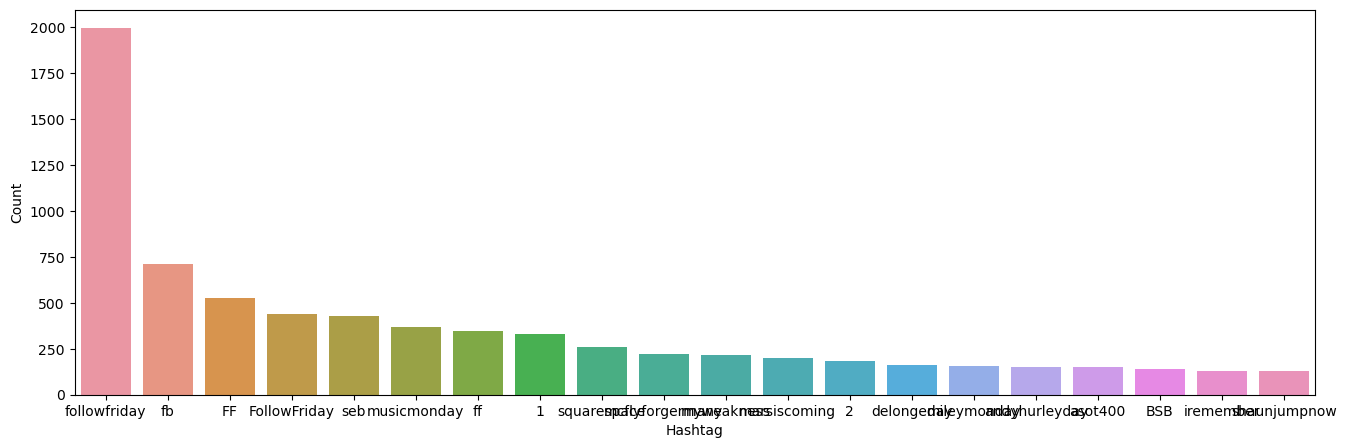

In [19]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [20]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

## Cleaning the text

In [21]:
%%time
df['clean_text'] = df.text.apply(preprocess_apply)

Wall time: 1min 25s


In [22]:
df

,text,target,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,<user> <url> aww thatis a bummer you shou...
1,is upset that he can't update his Facebook by ...,0,is upset that he cannot update his facebook by...
2,@Kenichan I dived many times for the ball. Man...,0,<user> i dived many times for the ball manage...
3,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",0,<user> no it is not behaving at all i am mad...
...,...,...,...
1599995,Just woke up. Having no school is the best fee...,1,just woke up having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,thewdb com very cool to hear old walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,are you ready for your mojo makeover ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday to my boo of all time tu...


In [23]:
count=0
for row in df.itertuples():
    print("Text:", row[1])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

In [24]:
# Analysing the data
cleantext = list(df['clean_text'])
data_positive = cleantext[800000:]
data_negative = cleantext[:800000]

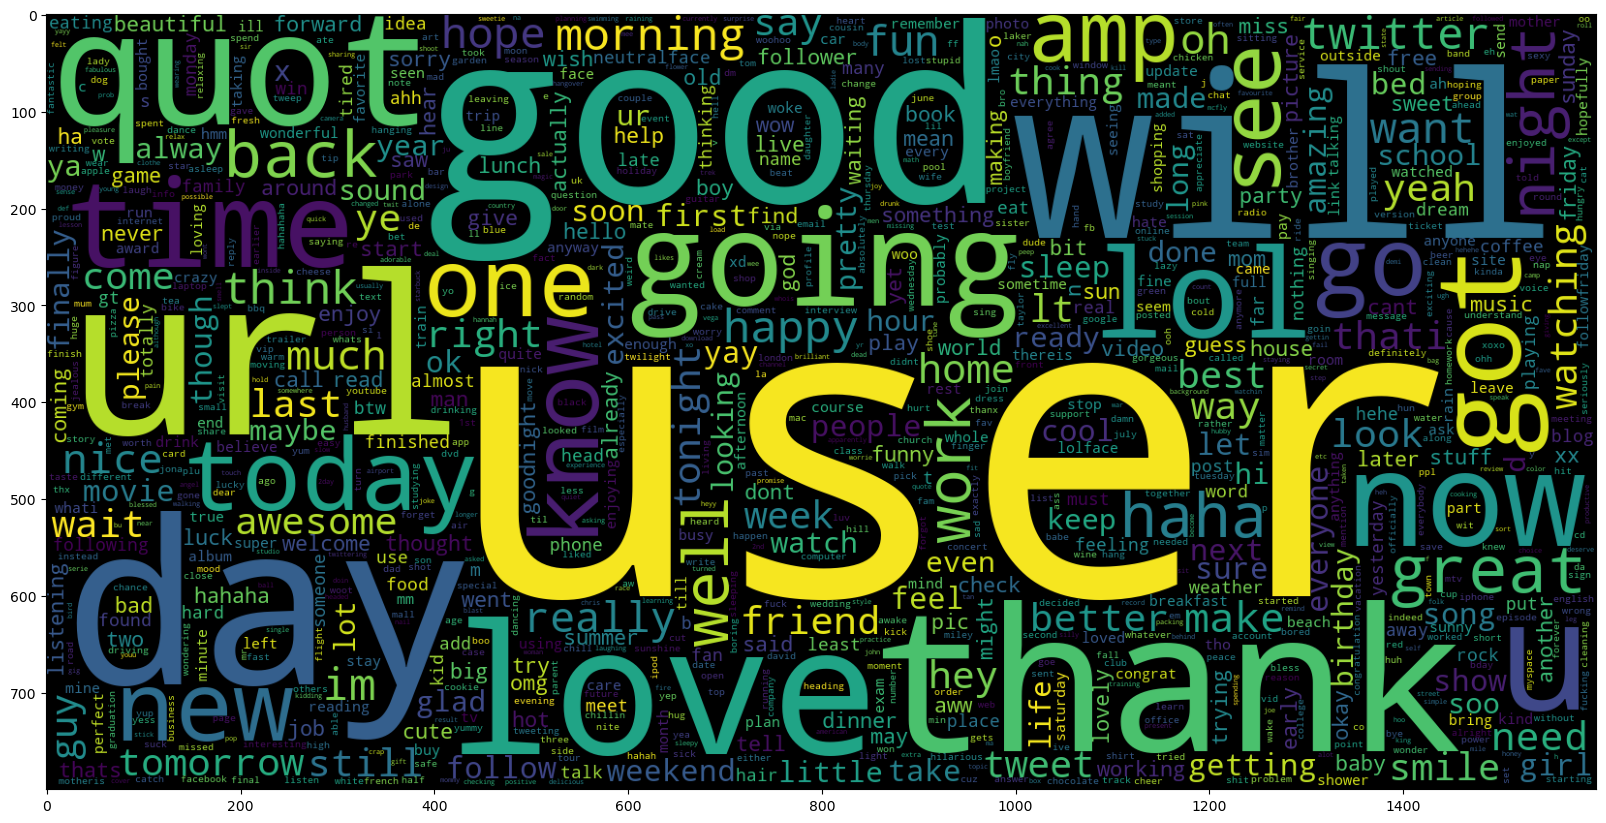

In [25]:
# Wordcloud for positives
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_positive))
plt.figure(figsize = (20,20))
plt.imshow(wc)

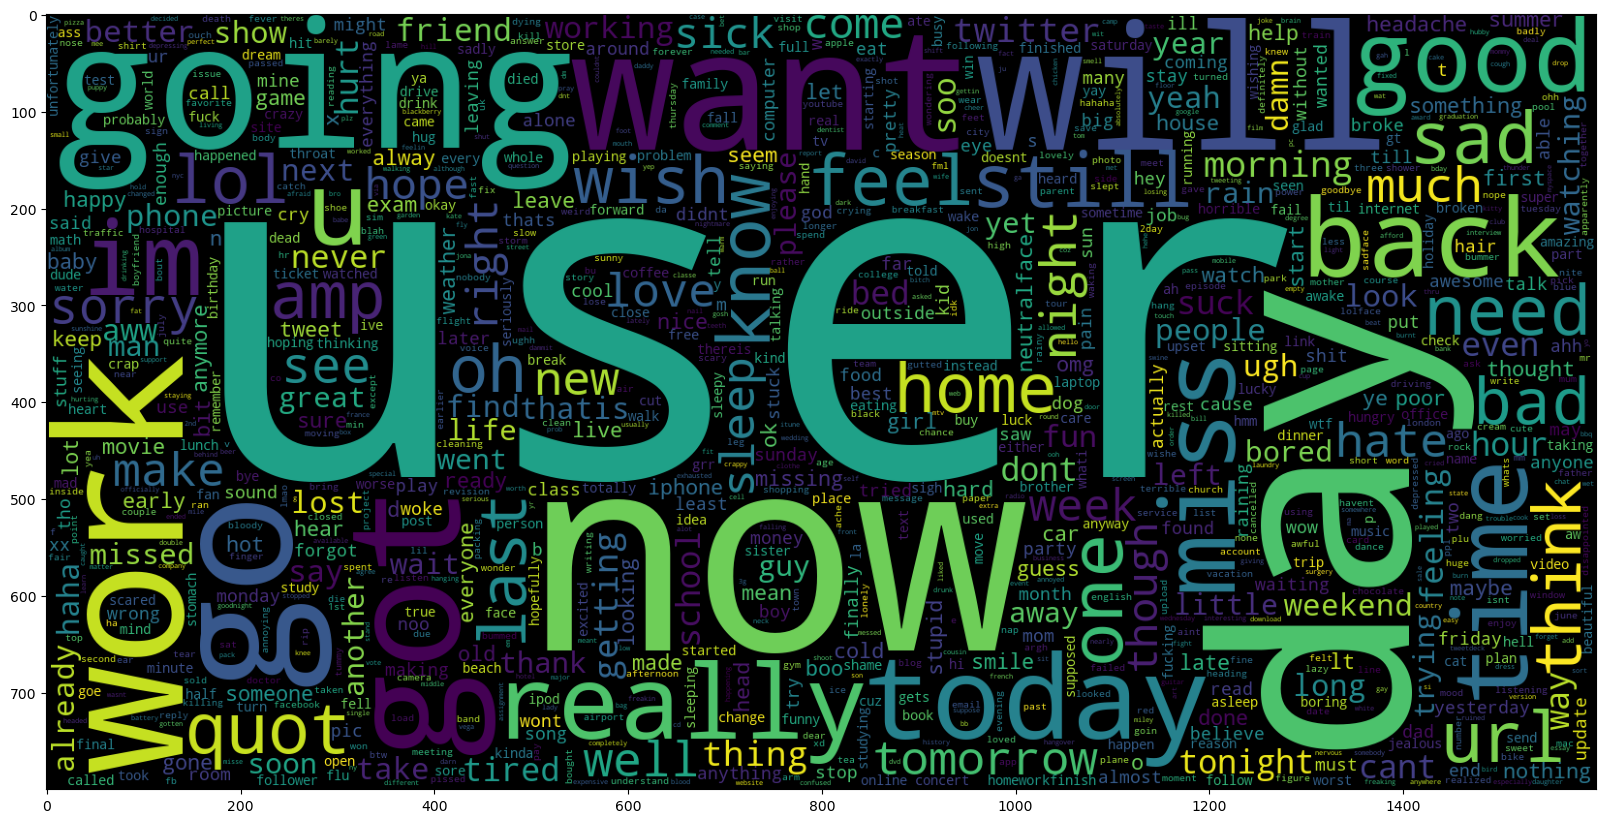

In [26]:
# Wordcloud for negatives
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_negative))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [27]:
# Splitting the data 
from sklearn.model_selection import train_test_split
X_data,y_data = np.array(df['clean_text']),np.array(df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size = 0.05, random_state = 0)

In [28]:
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 25000

In [29]:
# Creating Word Embeddings 
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [30]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 52025
Wall time: 1min 21s


In [31]:
pip install tensorflow==2.9.1

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [33]:
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
vocab_length = 60000
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [35]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [36]:
# Creating Embedding Matrix 
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [39]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, GlobalMaxPool1D, Embedding,Dropout
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# define the model architecture
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(512, activation='relu'),
        Dense(512,activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model







In [40]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dense_1 (Dense)             (None, 512)           

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] 

In [42]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 [==============================] - 2951s 2s/step - loss: 0.4275 - accuracy: 0.8003 - val_loss: 0.3890 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 2/12
1336/1336 [==============================] - 4795s 4s/step - loss: 0.3923 - accuracy: 0.8211 - val_loss: 0.3756 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/12
1336/1336 [==============================] - 3444s 3s/step - loss: 0.3807 - accuracy: 0.8274 - val_loss: 0.3709 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 4/12
1336/1336 [==============================] - 2837s 2s/step - loss: 0.3741 - accuracy: 0.8311 - val_loss: 0.3657 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 5/12
1336/1336 [==============================] - 3381s 3s/step - loss: 0.3686 - accuracy: 0.8339 - val_loss: 0.3658 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 6/12
1336/1336 [==============================] - 8601s 6s/step - loss: 0.3645 - accuracy: 0.8361 - val_loss: 0.3622 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 7/12
1336/1336 [========================

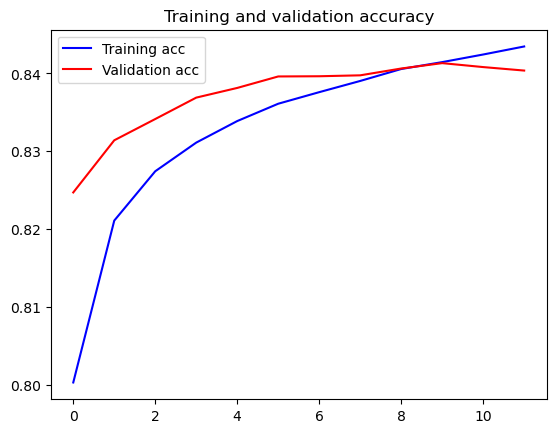

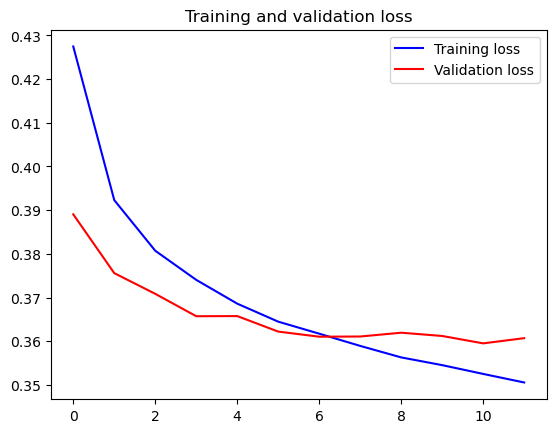

In [44]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 [==============================] - 61s 19ms/step


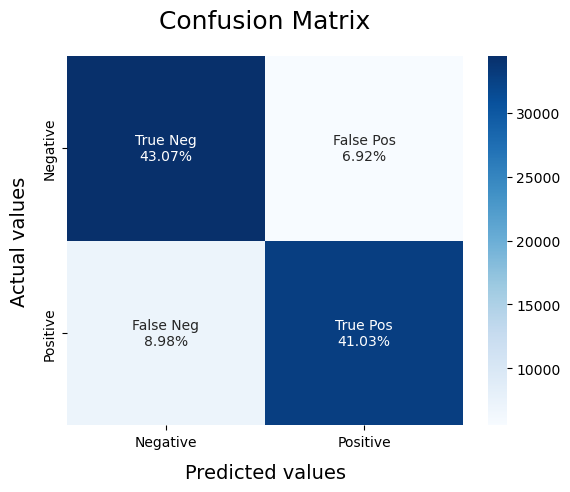

In [46]:
 # Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [47]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     39989
           1       0.86      0.82      0.84     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [49]:
# Saving Word2Vec-Model
import pickle 
word2vec_model.wv.save('models1/Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('models1/Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('models1/Sentiment-BiLSTM')
training_model.save_weights("models1/Model Weights/weights")

INFO:tensorflow:Assets written to: models1/Sentiment-BiLSTM\assets


INFO:tensorflow:Assets written to: models1/Sentiment-BiLSTM\assets


In [ ]:
import pickle
from tensorflow.keras.models import load_model

# Load the tokenizer
with open('Tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the Word2Vec model
word2vec_model = KeyedVectors.load('models1/Word2Vec-twitter-100')

# Load the trained model
trained_model = load_model('models1/Sentiment-BiLSTM')

# Compile the trained model
trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the text you want to classify
text = "This is a positive review."

# Tokenize the text
sequences = tokenizer.texts_to_sequences([text])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Convert the text to word embeddings using the Word2Vec model
word_embeddings = np.zeros((len(sequences[0]), EMBEDDING_DIM))
for i, word in enumerate(tokenizer.word_index.keys()):
    if word in word2vec_model:
        word_embeddings[i] = word2vec_model[word]

# Make predictions
predictions = trained_model.predict([padded_sequences, word_embeddings])

# Print the predicted sentiment
if predictions > 0.5:
    print("Positive sentiment")
else:
    print("Negative sentiment")
